In [588]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print(sys.version_info)
import re
import pprint
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
pp = pprint.PrettyPrinter(indent=4)
print('pandas version ' + pd.__version__)

sys.version_info(major=3, minor=7, micro=0, releaselevel='final', serial=0)
pandas version 1.1.5


In [604]:
#Pass a dataframe with feature columns and 'Survived' column
#This will train on 80% of data and cross-validate on 20% of the data
def train_and_fit(df_x, df_y,rand_state):
    logisticRegr = LogisticRegression()
    x_train,x_test,y_train,y_test = train_test_split(df_x,df_y,test_size = 0.20,random_state=rand_state)
    logisticRegr.fit(x_train,y_train)
    score = logisticRegr.score(x_test, y_test)
    coefs = pd.DataFrame(list(zip(df_x.columns,logisticRegr.coef_[0])))
    coefs = coefs.append(pd.DataFrame.from_dict({0:'Intercept',1:logisticRegr.intercept_}),ignore_index=True)
    print('Accuracy on CV set: ' +str(score))
    #print('Coefficients of logistic regression: ' + str(coefs))
    coefs.plot.bar(x=0,y=1)
    return logisticRegr
    
    
def k_fold_display(df_x,df_y,folds=10):
    logisticRegr = LogisticRegression()
    scores = cross_val_score(logisticRegr, df_x, df_y, cv=folds)
    print('CV scores: ' + str(scores))
    print('CV mean score: ' + str(np.mean(scores)))
    



def get_last_name(full_name):
    return re.findall('(.*),(.*)',full_name)[0][0]

def get_maiden_name(full_name):
     findmatch = re.findall('(.*)\((.*) ([^ ]*)\)',full_name)
     if len(findmatch) == 0:
        return np.nan
     else:
        return findmatch[0][2]

In [658]:
#Predicting survival based off of family members:
# 1. Create Last name column, fam size column
# 2. Groupby those two attributes above
# 2a. need to check if some families are mistaken by this
# 3. For each group, calculate the mean survival value
# 4. Use that as a feature in the SVM?

train1 = pd.read_csv('train.csv')
test1 = pd.read_csv('test.csv')
all1 = pd.concat([train1.copy(),test1.copy()])
all1['_Last'] = all1['Name'].apply(get_last_name) 
#all1['_Maiden'] = all1['Name'].apply(get_maiden_name) 
all1['_FamMembers'] = all1['SibSp'] + all1['Parch'] + 1
all1 = all1.set_index('PassengerId')
famsurvival_all = all1[all1['_FamMembers'] > 1].groupby(['_Last','_FamMembers'])
famsurvival = famsurvival_all['Survived']
famsurvival_tmean = famsurvival.transform(np.nanmean)
famsurvival_tcount = famsurvival.transform(lambda x: len(x))
famsurvival_tmean = famsurvival_tmean.rename('_FamSurvival')
#famsurvival_tcount = famsurvival_tcount.rename('_NameMembers')
all1 = pd.merge(all1,famsurvival_tmean,how='outer',left_index=True,right_index=True)
#all4 = pd.merge(all3,famsurvival_tcount,how='outer',left_index=True,right_index=True)
#all1['_NameMembers'] = all1['_NameMembers'].fillna(1)
all1['_FamSurvival'] = all1['_FamSurvival'].fillna(0.3838)
all1['_FamSurvival'] = 2*(all1[['_FamSurvival']]-0.5)

In [659]:
#Create categorical indicator variables for the following in cat_cols:
cat_cols = ["Pclass"]
all2 = all1.copy()
for catvar in cat_cols:
    all2 = all2.join(pd.get_dummies(all6[catvar],prefix=catvar))
    
#remove the columns that we made dummie variables for
cols = all2.columns.values.tolist()
keep_vars = [x for x in cols if x not in cat_cols]
all2 = all2.loc[:,keep_vars]
all2['Female'] = all2['Sex'].apply(lambda x: 1 if x == 'female' else 0)
all2 = all2.drop(['Sex'],axis=1)

Accuracy on CV set: 0.776536312849162
CV scores: [0.81111111 0.79775281 0.76404494 0.84269663 0.79775281 0.7752809
 0.76404494 0.74157303 0.80898876 0.76404494]
CV mean score: 0.786729088639201


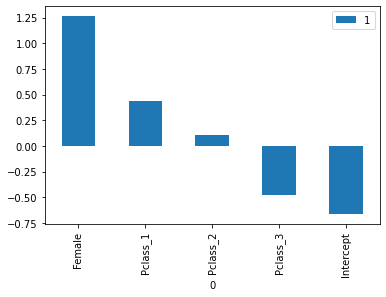

In [660]:
#Select only certain columns to perform analysis on.
all3 = all2.copy()
all3_x = all3[['Female','Pclass_1','Pclass_2', 'Pclass_3']].apply((lambda x: (x - x.mean())/x.std(ddof=0)))
all3_y = all3['Survived']
train3_x = all3_x[all3['Survived'].isna() == False]
train3_y = all3_y[all3['Survived'].isna() == False]

train_and_fit(train3_x,train3_y,1)
k_fold_display(train3_x,train3_y)

Accuracy on CV set: 0.7486033519553073
CV scores: [0.81111111 0.85393258 0.75280899 0.83146067 0.82022472 0.78651685
 0.76404494 0.75280899 0.83146067 0.78651685]
CV mean score: 0.7990886392009988


6

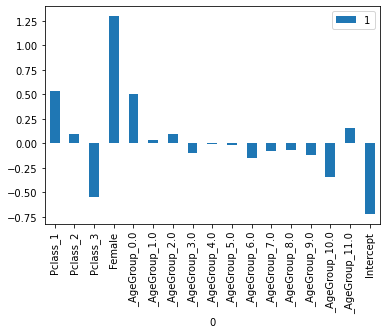

In [673]:
#Select only certain columns to perform analysis on.
all4 = all2.copy()
all4.loc[:,'_AgeGroup'] = np.floor_divide(all4['Age'].fillna(30),7)
all4 = all4.join(pd.get_dummies(all4['_AgeGroup'],prefix='_AgeGroup'))
all4_x = all4.drop(['Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 
        'Fare', 'Cabin','Embarked', '_Last', '_FamMembers','_FamSurvival','_AgeGroup'],axis=1) \
        .apply((lambda x: (x - x.mean())/x.std(ddof=0)))
all4_y = all4['Survived']
train4_x = all4_x[all4['Survived'].isna() == False]
train4_y = all4_y[all4['Survived'].isna() == False]

model = train_and_fit(train4_x,train4_y,1)
k_fold_display(train4_x,train4_y)
(train4_x['_AgeGroup_10.0'] > 0).sum()

Accuracy on CV set: 0.776536312849162
CV scores: [0.81111111 0.79775281 0.76404494 0.85393258 0.79775281 0.7752809
 0.7752809  0.74157303 0.80898876 0.7752809 ]
CV mean score: 0.7900998751560551


0.3838383838383838

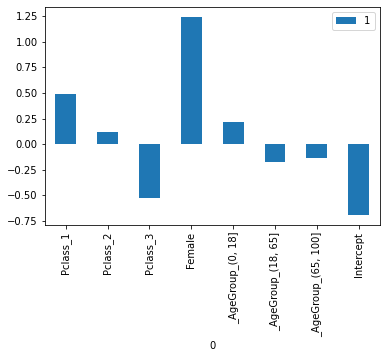

In [662]:
#Select only certain columns to perform analysis on.
all4 = all2.copy()
all4.loc[:,'_AgeGroup'] = pd.cut(all4['Age'].fillna(30),bins=[0,18,65,100])
all4 = all4.join(pd.get_dummies(all4['_AgeGroup'],prefix='_AgeGroup'))
all4_y = all4['Survived']
all4 = all4.drop(['Name', 'Age', 'SibSp', 'Parch', 'Ticket', 
        'Fare', 'Cabin','Embarked', '_Last', '_FamMembers','_AgeGroup','_FamSurvival'],axis=1) \
        .apply((lambda x: (x - x.mean())/x.std(ddof=0)))
all4_x = all4.drop(['Survived'],axis=1)
train4_x = all4_x[all4['Survived'].isna() == False]
train4_y = all4_y[all4['Survived'].isna() == False]

test4 = all4[all4['Survived'].isna() == True].drop(['Survived'],axis=1)

model = train_and_fit(train4_x,train4_y,1)
k_fold_display(train4_x,train4_y)

test4.loc[:,'Survived'] = model.predict(test4)
test4[['Survived']].to_csv('submission2_8may22.csv',index_label='PassengerId')
test4.loc[(test4['Survived'] == 0) | (test4['Survived'] == 1),'Survived'].shape
train4_y.groupby(train4_y).count()
train4_y.mean()

Accuracy on CV set: 0.776536312849162
CV scores: [0.81111111 0.79775281 0.76404494 0.84269663 0.79775281 0.7752809
 0.76404494 0.74157303 0.80898876 0.76404494]
CV mean score: 0.786729088639201


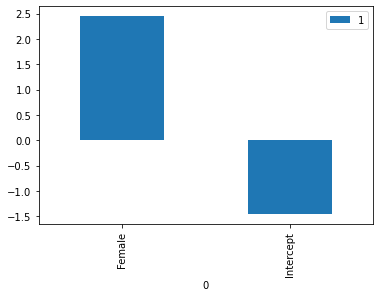

In [663]:
#Select only certain columns to perform analysis on.
all4 = all2.copy()
all4_y = all4['Survived']
all4_x = all4.drop(['Survived'],axis=1)
train4_x = all4_x[all4['Survived'].isna() == False]
train4_y = all4_y[all4['Survived'].isna() == False]

test4 = all4[all4['Survived'].isna() == True].drop(['Survived'],axis=1)

model = train_and_fit(train4_x[['Female']],train4_y,1)
k_fold_display(train4_x[['Female']],train4_y)

#test4.loc[:,'Survived'] = model.predict(test4)
#test4[['Survived']].to_csv('submission2_8may22.csv',index_label='PassengerId')


<AxesSubplot:>

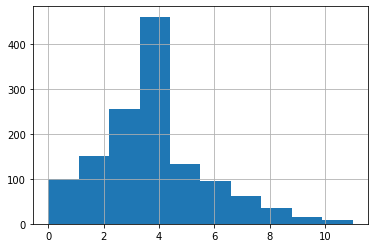

In [664]:
np.floor_divide(all2['Age'].fillna(30),7).hist()

0.8041958041958042
             0         1
0          Age  0.422497
1         Fare  0.087289
2     Pclass_1  0.499491
3     Pclass_2  0.047309
4     Pclass_3 -0.479011
5      Parch_0 -0.013839
6      Parch_1  0.186934
7      Parch_2 -0.097773
8      Parch_3  0.032481
9      Parch_4 -0.326733
10     Parch_5 -0.051251
11     Parch_6 -0.178772
12  Embarked_C  0.019337
13  Embarked_Q -0.093933
14  Embarked_S -0.165702
15      Female  1.172017
16   Intercept -0.519037


<AxesSubplot:xlabel='0'>

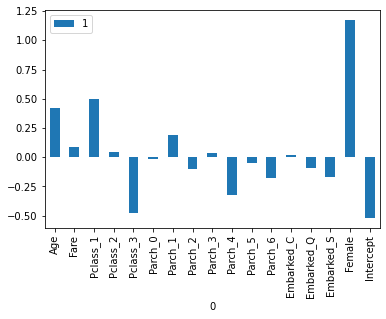

In [444]:
#This logstic model includes sex, plus other columns, its accuracy on the test set is about 80.4%
logisticRegr = LogisticRegression()
x_train,x_test,y_train,y_test = train_test_split(data3,datay,test_size = 0.20,random_state=0)
logisticRegr.fit(x_train,y_train)
score = logisticRegr.score(x_test, y_test)
coefs = pd.DataFrame(list(zip(data6.columns,logisticRegr.coef_[0])))
coefs = coefs.append(pd.DataFrame.from_dict({0:'Intercept',1:logisticRegr.intercept_}),ignore_index=True)
print(score)
print(coefs)
coefs.plot.bar(x=0,y=1)

In [445]:
#This logistic regression model only uses sex as a feature and its accuracy on the test set
#is about 79.7%
data7 = np.array(data6['Female']).reshape(-1,1)
logisticRegr = LogisticRegression()
x_train,x_test,y_train,y_test = train_test_split(data3[['Female']],datay,test_size = 0.20,random_state=0)
logisticRegr.fit(x_train,y_train)
score = logisticRegr.score(x_test, y_test)
print(score)
print(logisticRegr.coef_)
print(logisticRegr.intercept_)

0.7972027972027972
[[1.14760121]]
[-0.47894096]


In [446]:
allcol.groupby('Parch').agg({"Survived":['count','mean']})

Survived          
         count      mean
Parch                   
0          678  0.343658
1          118  0.550847
2           80  0.500000
3            5  0.600000
4            4  0.000000
5            5  0.200000
6            1  0.000000

0.8111888111888111
             0         1
0          Age  0.406683
1         Fare  0.076298
2     Pclass_1  0.448888
3     Pclass_2  0.000000
4     Pclass_3 -0.530782
5      Parch_0  0.000000
6      Parch_1  0.194946
7      Parch_2 -0.072419
8      Parch_3  0.027515
9      Parch_4 -0.234746
10     Parch_5 -0.040105
11     Parch_6 -0.111444
12  Embarked_C  0.164781
13  Embarked_Q -0.005768
14  Embarked_S  0.000000
15      Female  1.167659
16   Intercept -0.499609


<AxesSubplot:xlabel='0'>

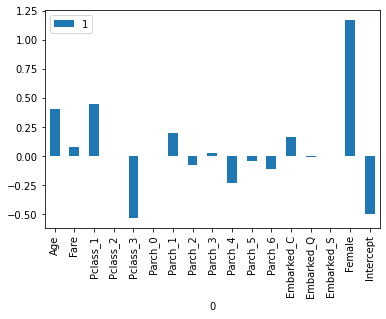

In [447]:
#This logstic model includes sex, plus other columns, its accuracy on the test set is about 81.1%
logisticRegr = LogisticRegression(penalty = 'l1',solver='liblinear')
x_train,x_test,y_train,y_test = train_test_split(data3,datay,test_size = 0.20,random_state=0)
logisticRegr.fit(x_train,y_train)
score = logisticRegr.score(x_test, y_test)
coefs = pd.DataFrame(list(zip(data6.columns,logisticRegr.coef_[0])))
coefs = coefs.append(pd.DataFrame.from_dict({0:'Intercept',1:logisticRegr.intercept_}),ignore_index=True)
print(score)
print(coefs)
coefs.plot.bar(x=0,y=1)

In [448]:


data3a = pd.merge(data3,all5,how='left',left_index=True,right_index=True)

dftest = pd.merge(data3a,datay,left_index=True,right_index=True)

0.8811188811188811
               0         1
0            Age  0.305156
1           Fare  0.177489
2       Pclass_1  0.404415
3       Pclass_2 -0.044458
4       Pclass_3 -0.316910
5        Parch_0  0.086513
6        Parch_1 -0.107221
7        Parch_2  0.070767
8        Parch_3  0.004962
9        Parch_4 -0.254207
10       Parch_5  0.016734
11       Parch_6 -0.088864
12    Embarked_C -0.150580
13    Embarked_Q -0.159979
14    Embarked_S -0.167987
15        Female  1.359921
16  _FamSurvival  3.689322
17     Intercept -0.577442


,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S,Female,_FamSurvival
PassengerId,,,,,,,,,,,,,,,,,
690,1.012592,3.340332,1.684847,-0.565489,-0.994413,-1.643010,2.343269,-0.324443,-0.083977,-0.075059,-0.083977,-0.03745,-0.471808,-0.202031,0.537409,1.317434,1.0
279,1.563696,-0.105320,-0.593526,-0.565489,1.005618,-1.643010,2.343269,-0.324443,-0.083977,-0.075059,-0.083977,-0.03745,-0.471808,4.949747,-1.860779,-0.759051,-1.0
507,-0.227391,-0.164414,-0.593526,1.768380,-0.994413,-1.643010,-0.426754,3.082207,-0.083977,-0.075059,-0.083977,-0.03745,-0.471808,-0.202031,0.537409,1.317434,1.0
10,1.081480,-0.087435,-0.593526,1.768380,-0.994413,0.608639,-0.426754,-0.324443,-0.083977,-0.075059,-0.083977,-0.03745,2.119506,-0.202031,-1.860779,1.317434,0.0
495,0.599265,-0.503850,-0.593526,-0.565489,1.005618,0.608639,-0.426754,-0.324443,-0.083977,-0.075059,-0.083977,-0.03745,-0.471808,-0.202031,0.537409,-0.759051,0.0
150,-0.847383,-0.410245,-0.593526,1.768380,-0.994413,0.608639,-0.426754,-0.324443,-0.083977,-0.075059,-0.083977,-0.03745,-0.471808,-0.202031,0.537409,-0.759051,0.0
474,0.461489,-0.395274,-0.593526,1.768380,-0.994413,0.608639,-0.426754,-0.324443,-0.083977,-0.075059,-0.083977,-0.03745,2.119506,-0.202031,-1.860779,1.317434,0.0
468,-1.811815,-0.154013,1.684847,-0.565489,-0.994413,0.608639,-0.426754,-0.324443,-0.083977,-0.075059,-0.083977,-0.03745,-0.471808,-0.202031,0.537409,-0.759051,0.0
796,-0.640719,-0.410245,-0.593526,1.768380,-0.994413,0.608639,-0.426754,-0.324443,-0.083977,-0.075059,-0.083977,-0.03745,-0.471808,-0.202031,0.537409,-0.759051,0.0


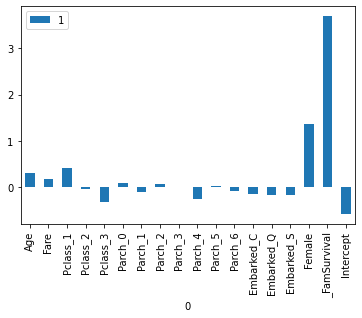

In [449]:
logisticRegr = LogisticRegression()
x_train,x_test,y_train,y_test = train_test_split(data3a,datay,test_size = 0.20,random_state=1)
logisticRegr.fit(x_train,y_train)
score = logisticRegr.score(x_test, y_test)
coefs = pd.DataFrame(list(zip(data3a.columns,logisticRegr.coef_[0])))
coefs = coefs.append(pd.DataFrame.from_dict({0:'Intercept',1:logisticRegr.intercept_}),ignore_index=True)
print(score)
print(coefs)
coefs.plot.bar(x=0,y=1)
x_test.head(30)

In [450]:
df1 = pd.DataFrame({'a':[1,2,3], 'b':[4,5,6]})
df2 = pd.DataFrame({'c':[7,8,9,10]})

df1.loc[:,'d'] = df2['c']
df1

,a,b,d
0,1,4,7
1,2,5,8
2,3,6,9


Accuracy on CV set: 0.8811188811188811


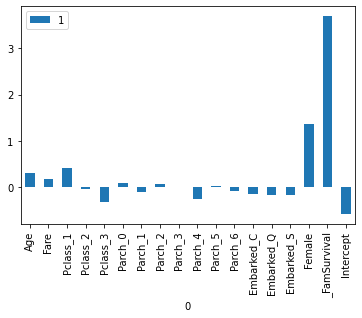

In [351]:
train_and_fit(dftest)

In [359]:
all7['Sex'].isna().sum()

0

In [451]:
train1.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')